In [1]:
from typing import List, Tuple, Callable, TypedDict, Dict, Optional
from abc import ABC, abstractmethod
from enum import Enum
import random
import json
import os
import io

from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate, IGate, RYGate, HGate 
from qiskit import generate_preset_pass_manager
from qiskit.circuit.classical import expr
from qiskit.circuit import ParameterVector

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2

from random_utility import RandomUtility

In [2]:
TOTAL_RUNS = 1000

In [3]:
classical_strategies = ("Probability based", "Shoot Opponent", "Shoot Randomly", "Shoot Himself")

In [4]:
class Shell:
    BLANK=0
    LIVE=1

In [5]:
class Play:
    HIMSELF=0
    OPPONENT=1

In [6]:
class RandomEngine(ABC):
    @abstractmethod
    def set_seed(self, seed:int):
        pass

    @abstractmethod
    def get_random_value(self, values:Optional[List[float]]=None) -> int:
        pass

In [7]:
class DefaultRandomEngine(RandomEngine):
    def set_seed(self, seed:int):
        pass

    def get_random_value(self,values:Optional[List[float]]=None) -> int:
        if(values is None):
            return int(random.random() < 0.5)
        
        return random.choice(values)
        

In [8]:
class CppRandomEngine(RandomEngine):
    def __init__(self):
        super().__init__()
        self._random_util = RandomUtility()
        
    def set_seed(self, seed:int):
        self._random_util.set_seed(seed)

    def get_random_value(self,values:Optional[List[float]]=None) -> int:
        if(values is None):
            return self._random_util.get_random_value()

        t_values = len(values)
        prob = 1/t_values
        dist_probs = [prob]*t_values
        selected_i = self._random_util.get_random_value_by_array(dist_probs)

        return values[selected_i]

In [9]:
class Player(ABC):

    def __init__(self, life:int, name:str, random_engine:RandomEngine):
        self._life = life
        self._points = 0
        self._name = name
        self._randomng = random_engine()

    @abstractmethod
    def play(self, bullets:List[Shell]) -> Play:
        """Think and then play"""
        pass

    def decrease_life(self):
        self._life -= 1

    def add_point(self):
        self._points += 1

    @property
    def randomng(self) -> RandomEngine:
        return self._randomng

    @property
    def name(self) -> str:
        return self._name

    @property
    def points(self) -> int:
        return self._points

    @property
    def life(self) -> int:
        return self._life

    @property
    def is_alive(self) -> bool:
        return self._life > 0

    def __str__(self):
        return self._name
    
    def __repr__(self):
        return self._name

In [10]:
class Game:
    def __init__(
        self,
        bullets: List[Shell],
        players: List[Player],
        random_engine: RandomEngine
    ):
        self._bullets = bullets
        self._players = players

        self._rounds = 0

        self._total_players = len(players)
        self._current_player_i = 0

        self._randomng = random_engine()

    def _get_next_player_i(self) -> int:
        return (self._current_player_i+1)%self._total_players

    def set_seed(self, seed:int):
        self._randomng.set_seed(seed)
        for player in self._players:
            player.randomng.set_seed(seed)

    @property
    def _opponent(self) -> Player:
        return self._players[self._get_next_player_i()]

    def _set_next_player(self):
        self._current_player_i = self._get_next_player_i()

    @property
    def _current_player(self) -> Player:
        return self._players[self._current_player_i]

    @property
    def _next_bullet(self) -> Shell:
        bullet = self._randomng.get_random_value(self._bullets)
        self._bullets.remove(bullet)
        return bullet

    @property
    def _has_live_shells(self) -> bool:
        return self._bullets.count(Shell.LIVE) > 0

    @property
    def _both_players_are_alive(self) -> bool:
        return all([player.is_alive for player in self._players]) 

    @property
    def _has_ended(self) -> bool:
        return not self._has_live_shells or not self._both_players_are_alive

    @property
    def _winner(self) -> Player:
        return max(self._players, key=lambda p: p.points)


    def run(self, debug:bool=True) -> Tuple[Player, int]:
        while not self._has_ended:
            player = self._current_player
            play = player.play(self._bullets)
            bullet = self._next_bullet

            if(play == Play.HIMSELF and bullet == Shell.BLANK):
                if(debug): print("Player shot himself and it was blank")
                continue
            elif(play == Play.HIMSELF and bullet == Shell.LIVE):
                if(debug):print("Player shot himself and it was live (-1)")
                player.decrease_life()
                self._opponent.add_point()
            elif(play == Play.OPPONENT and bullet == Shell.BLANK):

                if(debug):
                    print("Player shot his opponent and it was blank")
                    print("Next player")
                self._set_next_player()
            elif(play == Play.OPPONENT and bullet == Shell.LIVE):
                if(debug):
                    print("Player shot his opponent and it was Live (+1)")
                    print("Next player")
                self._opponent.decrease_life()
                self._set_next_player()
            
            self._rounds += 1
        
        if(debug): print("End game!")

        return self._winner, self._rounds








In [11]:
class Human1(Player):
    def play(self, bullets:List[Shell]) -> Play:
        total_live = bullets.count(Shell.LIVE)
        prob_of_live_shell = total_live/len(bullets)

        if(prob_of_live_shell >= 0.5):
            return Play.OPPONENT
        return Play.HIMSELF

In [12]:
class Human2(Player):
    def play(self, bullets:List[Shell]) -> Play:
        return Play.OPPONENT

In [13]:
class Human3(Player):
    def play(self, bullets:List[Shell]) -> Play:
        if(self._randomng.get_random_value()):
            return Play.OPPONENT
        return Play.HIMSELF

In [14]:
class Human4(Player):
    def play(self, bullets:List[Shell]) -> Play:
        return Play.HIMSELF

In [15]:
class Dealer(Player):
    def play(self, bullets:List[Shell]) -> Play:
        if(self._randomng.get_random_value()):
            return Play.OPPONENT
        return Play.HIMSELF

In [16]:
classical_results = pd.DataFrame(columns=("eval_i", "shot","winner", "strategy", "rounds"))
classical_results_cpp = pd.DataFrame(columns=("eval_i", "shot", "winner", "strategy", "rounds"))

for df,file,engine in zip((classical_results, classical_results_cpp), ('classical-results.csv', 'classical-results-cpp.csv'), (DefaultRandomEngine, CppRandomEngine)):

    for evaluation_i in trange(TOTAL_RUNS):
        random_util = RandomUtility()
        seed = random_util.seed
        rows = []

        for strategy_i, player in enumerate((Human1, Human2, Human3, Human4)):
            
            # pseudo shots
            for run in range(TOTAL_RUNS):
                game = Game(
                    [Shell.BLANK, Shell.BLANK, Shell.LIVE], 
                    [player(2, "player", engine), Dealer(2, "dealer", engine)], 
                    engine)
                game.set_seed(seed)
                winner,rounds = game.run(debug=False)
                rows.append({"eval_i":evaluation_i+1, "winner":winner.name, "shot":run+1, "strategy":strategy_i+1, "rounds":rounds+1})
        
        tmp_df = pd.DataFrame(rows)

        df = pd.concat([df,tmp_df],ignore_index=True)

    df.to_csv(file,index=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


---

In [17]:
def player1(total_bullets:int, amount_of_live_shells:int):
    prob_of_live_shell = amount_of_live_shells/total_bullets
    op = IGate().to_mutable()
    if(prob_of_live_shell >= 0.5):
        op = XGate().to_mutable()
    op.label = "P1"
    return op

In [18]:
def player2(total_bullets:int, amount_of_live_shells:int):
    op = XGate().to_mutable()
    op.label = "P2"
    return op

In [19]:
def player3(total_bullets:int, amount_of_live_shells:int):
    op = HGate().to_mutable()
    op.label = "P3"
    return op

In [20]:
def player4(total_bullets:int, amount_of_live_shells:int):
    op = IGate().to_mutable()
    op.label = "P4"
    return op

In [21]:
def dealer(total_bullets:int, amount_of_live_shells:int):
    op = HGate().to_mutable()
    op.label = "D"
    return op

In [22]:
def gun(total_bullets:int, amount_of_live_shells:int):
    theta = 2*np.arcsin(np.sqrt(amount_of_live_shells/total_bullets))
    op = RYGate(theta).to_mutable()
    op.label = "GUN"
    return op

In [23]:
# a type to define all the function calls we do inside the circuit
class BuckshotRouletteCalls(TypedDict):
    player_first_play: QuantumCircuit

    player_if_himself_1: QuantumCircuit
    
    player_if_player_2: QuantumCircuit
    dealer_if_player_2: QuantumCircuit

    dealer_if_shot_1: QuantumCircuit

    player_if_dealer_2:QuantumCircuit
    dealer_if_dealer_2:QuantumCircuit

In [24]:
def player_play(player:Callable, total_bullets_player:int, live_shells_player:int, name:str) -> QuantumCircuit:
    inner_qc = QuantumCircuit(3, name=name)
    inner_qc.append(player(total_bullets_player, live_shells_player), [0])
    inner_qc.append(gun(total_bullets_player, live_shells_player).control(1, ctrl_state='0'), [0,1])
    inner_qc.append(gun(total_bullets_player, live_shells_player).control(1), [0,2])
    return inner_qc

def dealer_play(dealer:Callable, total_bullets_dealer:int, live_shells_dealer:int, name:str) -> QuantumCircuit:
    inner_qc = QuantumCircuit(3, name=name)
    inner_qc.append(dealer(total_bullets_dealer, live_shells_dealer), [0])
    inner_qc.append(gun(total_bullets_dealer, live_shells_dealer).control(1, ctrl_state='0'), [0,1])
    inner_qc.append(gun(total_bullets_dealer, live_shells_dealer).control(1), [0,2])
    return inner_qc

In [25]:
def buckshot_roulette(calls:BuckshotRouletteCalls, gun:Callable, total_bullets:int=3, live_shells:int=1):
    assert total_bullets > 0, "INVALID NUMBER OF BULLETS" 
    assert live_shells <= total_bullets and live_shells >= 0, "INVALID NUMBER OF LIVE SHELLS"
   
    player_life  = QuantumRegister(3, name="p") 
    dealer_life  = QuantumRegister(3, name="d")

    game = QuantumRegister(3, name="game")

    player_life_out = ClassicalRegister(3, name="po")
    dealer_life_out = ClassicalRegister(3, name="do")
    choice = ClassicalRegister(3, name="b")
    
    qc = QuantumCircuit(game, player_life, dealer_life, choice, player_life_out, dealer_life_out)

    def get_shot(index:int) -> expr.Expr:
        return expr.bit_and( expr.bit_not(player_life_out[index]), expr.bit_not(dealer_life_out[index]) )


    #qc.append(player_play(total_bullets, live_shells, name="Player Bullet 1"), [game[0], player_life[0], dealer_life[0]])
    qc.append(calls["player_first_play"], [game[0], player_life[0], dealer_life[0]])

    qc.measure(game[0], choice[0])
    qc.measure(player_life[0], player_life_out[0])
    qc.measure(dealer_life[0], dealer_life_out[0])

    qc.barrier()

    shot_first = get_shot(0)
    first_player = expr.bit_and(shot_first, expr.bit_not(choice[0]))
    first_dealer = expr.bit_and(shot_first, choice[0])

    with qc.if_test(first_player):
        #qc.append(player_play(total_bullets-1, live_shells, name="Player Bullet 2"), [game[1], player_life[1], dealer_life[1]])
        qc.append(calls["player_if_himself_1"], [game[1], player_life[1], dealer_life[1]])
        qc.measure(game[1], choice[1])
        qc.measure(player_life[1], player_life_out[1])
        qc.measure(dealer_life[1], dealer_life_out[1])

        shot_second = get_shot(1)
        second_player = expr.bit_and(shot_second, expr.bit_not(choice[1]))
        second_dealer = expr.bit_and(shot_second, choice[1])

        with qc.if_test(second_player):
            #qc.append(player_play(total_bullets-2, live_shells, name="Player Bullet 3"), [game[2], player_life[2], dealer_life[2]])
            qc.append(calls["player_if_player_2"], [game[2], player_life[2], dealer_life[2]])
            qc.measure(game[2], choice[2])
            qc.measure(player_life[2], player_life_out[2])
            qc.measure(dealer_life[2], dealer_life_out[2])
        with qc.if_test(second_dealer):
            #qc.append(dealer_play(total_bullets-2, live_shells, name="Player Bullet 3"), [game[2], dealer_life[2], player_life[2]])
            qc.append(calls["dealer_if_player_2"], [game[2], dealer_life[2], player_life[2]])
            qc.measure(game[2], choice[2])
            qc.measure(player_life[2], player_life_out[2])
            qc.measure(dealer_life[2], dealer_life_out[2])


    
    with qc.if_test(first_dealer):
        #qc.append(dealer_play(total_bullets-1, live_shells, name="Dealer Bullet 2"), [game[1], dealer_life[1], player_life[1]])
        qc.append(calls["dealer_if_shot_1"], [game[1], dealer_life[1], player_life[1]])
        qc.measure(game[1], choice[1])
        qc.measure(player_life[1], player_life_out[1])
        qc.measure(dealer_life[1], dealer_life_out[1])


        shot_second = get_shot(1)
        second_dealer = expr.bit_and(shot_second, expr.bit_not(choice[1]))
        second_player = expr.bit_and(shot_second, choice[1])

        with qc.if_test(second_player):
            #qc.append(player_play(total_bullets-2, live_shells, name="Player Bullet 3"), [game[2], player_life[2], dealer_life[2]])
            qc.append(calls["player_if_dealer_2"], [game[2], player_life[2], dealer_life[2]])
            qc.measure(game[2], choice[2])
            qc.measure(player_life[2], player_life_out[2])
            qc.measure(dealer_life[2], dealer_life_out[2])
        with qc.if_test(second_dealer):
            #qc.append(dealer_play(total_bullets-2, live_shells, name="Player Bullet 3"), [game[2], dealer_life[2], player_life[2]])
            qc.append(calls["dealer_if_dealer_2"], [game[2], dealer_life[2], player_life[2]])
            qc.measure(game[2], choice[2])
            qc.measure(player_life[2], player_life_out[2])
            qc.measure(dealer_life[2], dealer_life_out[2])

    return qc

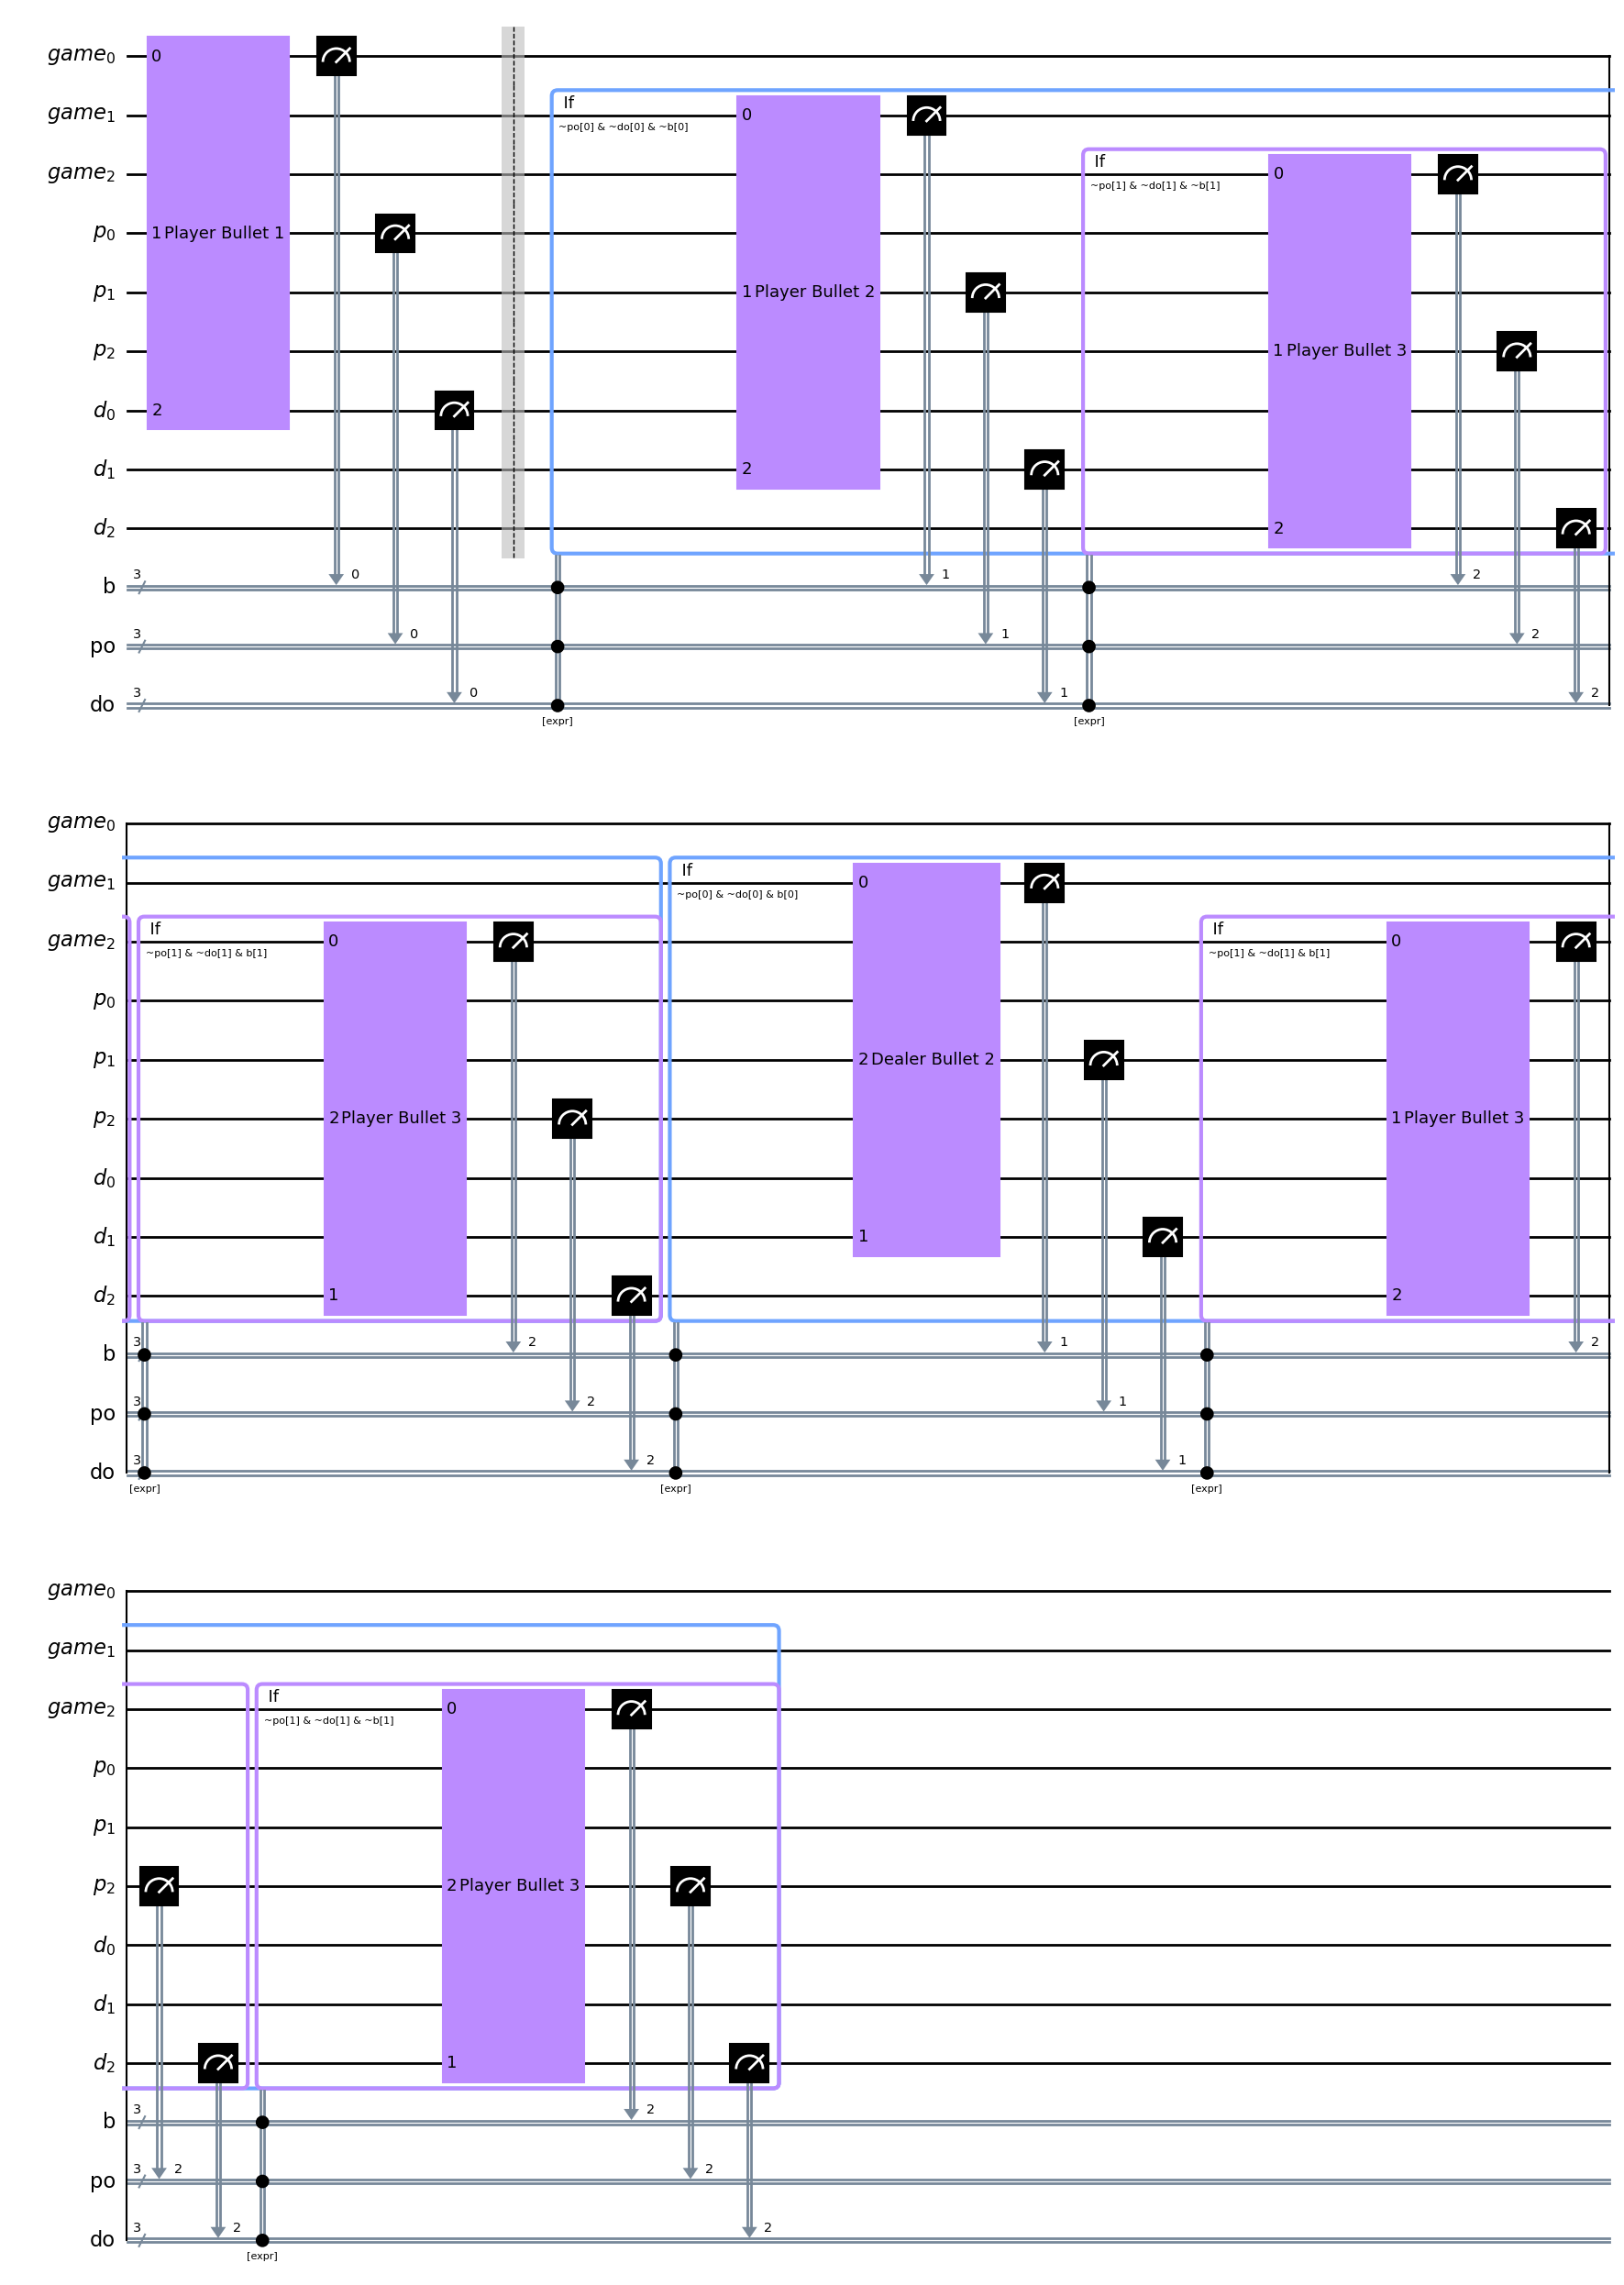

In [26]:
total_bullets = 3
live_shells = 1



calls = {
    "player_first_play": player_play(player1, total_bullets, live_shells, name="Player Bullet 1"),
    "player_if_himself_1": player_play(player1, total_bullets-1, live_shells, name="Player Bullet 2"),
    "player_if_player_2": player_play(player1, total_bullets-2, live_shells, name="Player Bullet 3"),
    "dealer_if_player_2": dealer_play(dealer, total_bullets-2, live_shells, name="Player Bullet 3"),
    "dealer_if_shot_1": dealer_play(dealer, total_bullets-1, live_shells, name="Dealer Bullet 2"),
    "player_if_dealer_2": player_play(player1, total_bullets-2, live_shells, name="Player Bullet 3"),
    "dealer_if_dealer_2": dealer_play(dealer, total_bullets-2, live_shells, name="Player Bullet 3")
}

qc = buckshot_roulette(calls, gun, total_bullets, live_shells)
qc.draw('mpl', style="clifford", filename="quantum-buckshot-roulette-circuit.png")

In [27]:
sim = AerSimulator()
sampler = SamplerV2()
pm = generate_preset_pass_manager(backend=sim, optimization_level=2)

In [28]:
Meas = Dict[str,int]

In [29]:
def who_won(measurements:Meas) -> List[Dict[str,int]]:
    results = []

    for bit_string, total in measurements.items():
        dealer_string = bit_string[:3][::-1]
        player_string = bit_string[3:6][::-1]
        #print("dealer=%s, player=%s"%(dealer_string, player_string))

        if('1' in dealer_string):
            results.append({"winner":"player", "total":total, "rounds":dealer_string.index('1')+1})

        elif('1' in player_string):
            results.append({"winner":"dealer", "total":total, "rounds":player_string.index('1')+1})



    return results

In [30]:
results_quantum = pd.DataFrame(columns=("eval_i", "winner", "strategy", "total", "rounds"))
total_bullets = 3
live_shells = 1

for evaluation_i in trange(TOTAL_RUNS):

    for strategy_i, player in enumerate((player1, player2, player3, player4)):

        calls = {
            "player_first_play": player_play(player, total_bullets, live_shells, name="Player Bullet 1"),
            "player_if_himself_1": player_play(player, total_bullets-1, live_shells, name="Player Bullet 2"),
            "player_if_player_2": player_play(player, total_bullets-2, live_shells, name="Player Bullet 3"),
            "dealer_if_player_2": dealer_play(dealer, total_bullets-2, live_shells, name="Player Bullet 3"),
            "dealer_if_shot_1": dealer_play(dealer, total_bullets-1, live_shells, name="Dealer Bullet 2"),
            "player_if_dealer_2": player_play(player, total_bullets-2, live_shells, name="Player Bullet 3"),
            "dealer_if_dealer_2": dealer_play(dealer, total_bullets-2, live_shells, name="Player Bullet 3")
        }


        qc = buckshot_roulette(calls, gun, total_bullets, live_shells)
        isa_qc = pm.run(qc)
        result = sampler.run([isa_qc], shots=TOTAL_RUNS).result()[0]
        measurements = dict(result.join_data().get_counts())

        results = [ {**result, "eval_i":evaluation_i+1, "strategy":strategy_i+1} for result in who_won(measurements) ]
        
        tmp_df = pd.DataFrame(results)
        results_quantum = pd.concat([results_quantum, tmp_df], ignore_index=True)

results_quantum.to_csv("quantum-results.csv", index=False)

100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


---

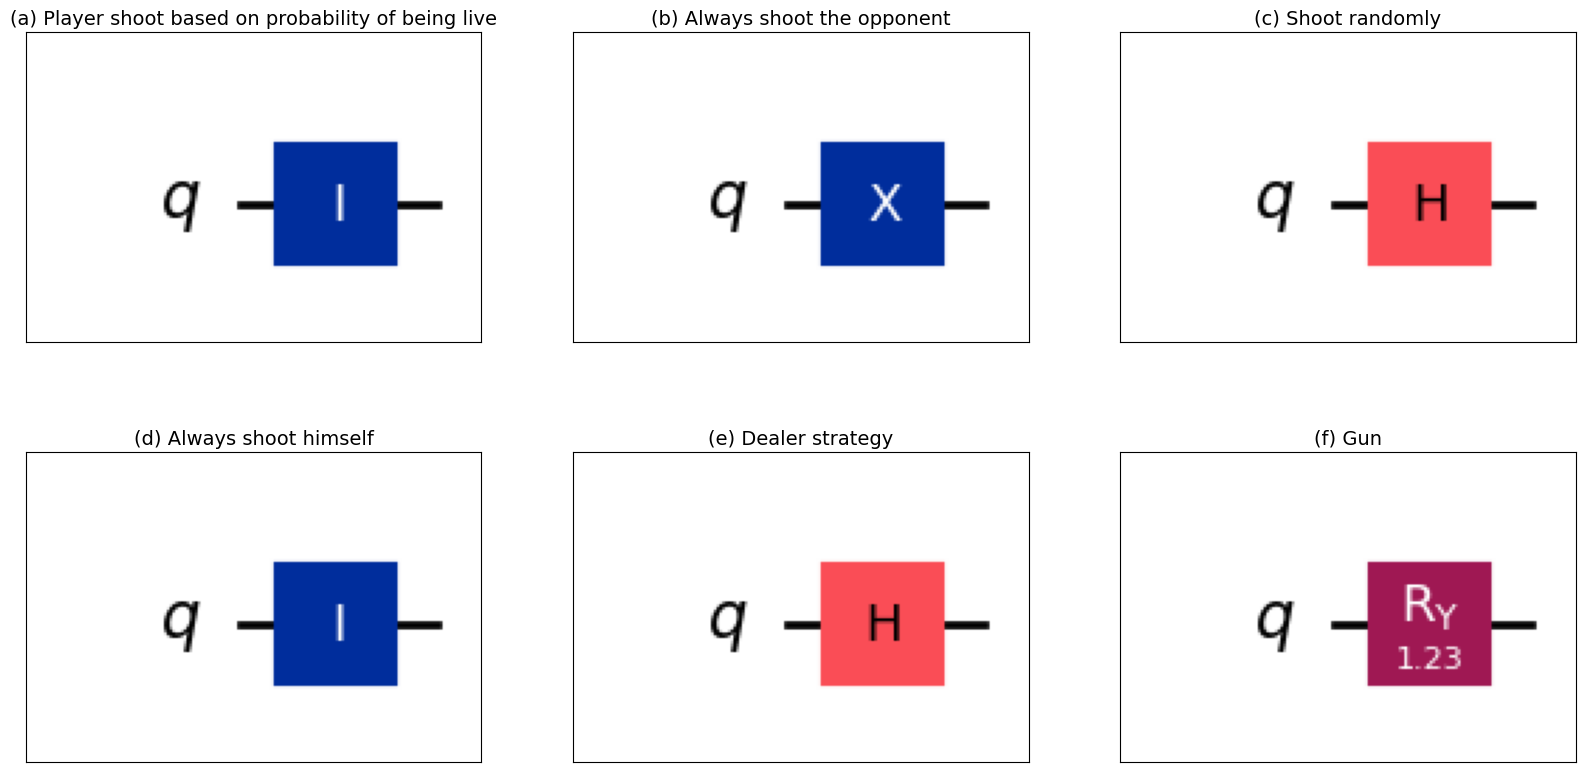

In [31]:
rows = 2
cols = 3

objs = (player1, player2, player3, player4, dealer,gun)
names = ('(a) Player shoot based on probability of being live', '(b) Always shoot the opponent', '(c) Shoot randomly', '(d) Always shoot himself', '(e) Dealer strategy', '(f) Gun')
current = 0

fig, ax = plt.subplots(rows,cols, figsize=(20,10))

for i in range(rows):
    for j in range(cols):
        ax[i,j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax[i,j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


        ax[i,j].set_title(names[current], fontsize=14)

        qc = QuantumCircuit(1)
        strategy = objs[current]
        op = strategy(3,1)
        op.label = None
        qc.append(op, [0])
        circuit = qc.draw('mpl')

        buf = io.BytesIO()
        circuit.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)

        img = Image.open(buf)

        ax[i,j].imshow(img)

        current += 1

fig.savefig('quantum-strategies.png', bbox_inches="tight")
plt.show()


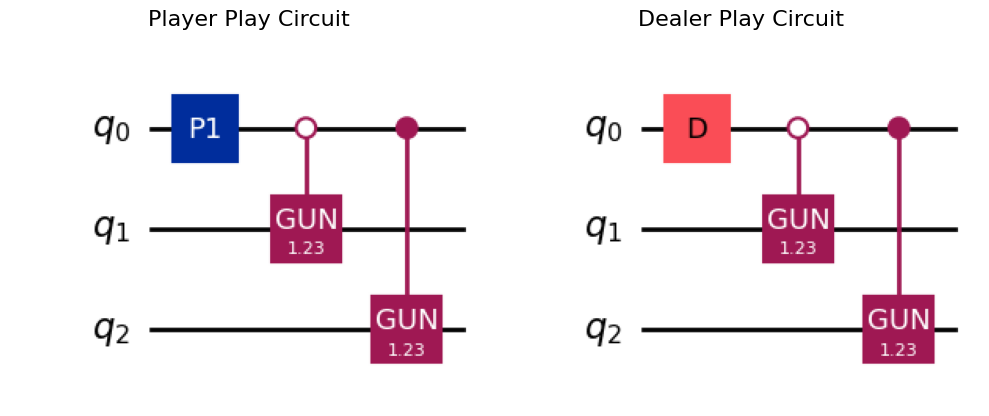

In [32]:
plots = 2
plays = (player_play(player1, 3, 1, name=""), dealer_play(dealer, 3, 1, name=""))
names = ("Player Play Circuit", "Dealer Play Circuit")

fig,ax = plt.subplots(1,plots,figsize=(10,5))

for i in range(plots):
    circuit = plays[i].draw('mpl')
    buf = io.BytesIO()
    circuit.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)

    img = Image.open(buf)

    ax[i].set_title(names[i], fontsize=16)

    ax[i].imshow(img)
    ax[i].axis('off')

fig.tight_layout()
fig.savefig('quantum-plays.png', bbox_inches="tight")
plt.show()

In [33]:
datasets = ("classical-results-cpp.csv", "classical-results.csv", "quantum-results.csv")
labels = ("cpp", "classical", "quantum")

In [34]:
data = pd.DataFrame(columns=("winner", "label", "strategy", "rounds"))

for label,dataset in zip(labels[:2],datasets[:2]):
    d = pd.read_csv(dataset)
    grouped_data = d.groupby(["eval_i", "strategy", "rounds","winner"]).size().reset_index(name="total")
    grouped_data.drop("eval_i", axis=1)
    grouped_data["label"] = label
    data = pd.concat([data,grouped_data], ignore_index=True)

q = pd.read_csv(datasets[-1])
q.drop("eval_i", axis=1)
q["label"] = labels[-1]
data = pd.concat([data,q], ignore_index=True)

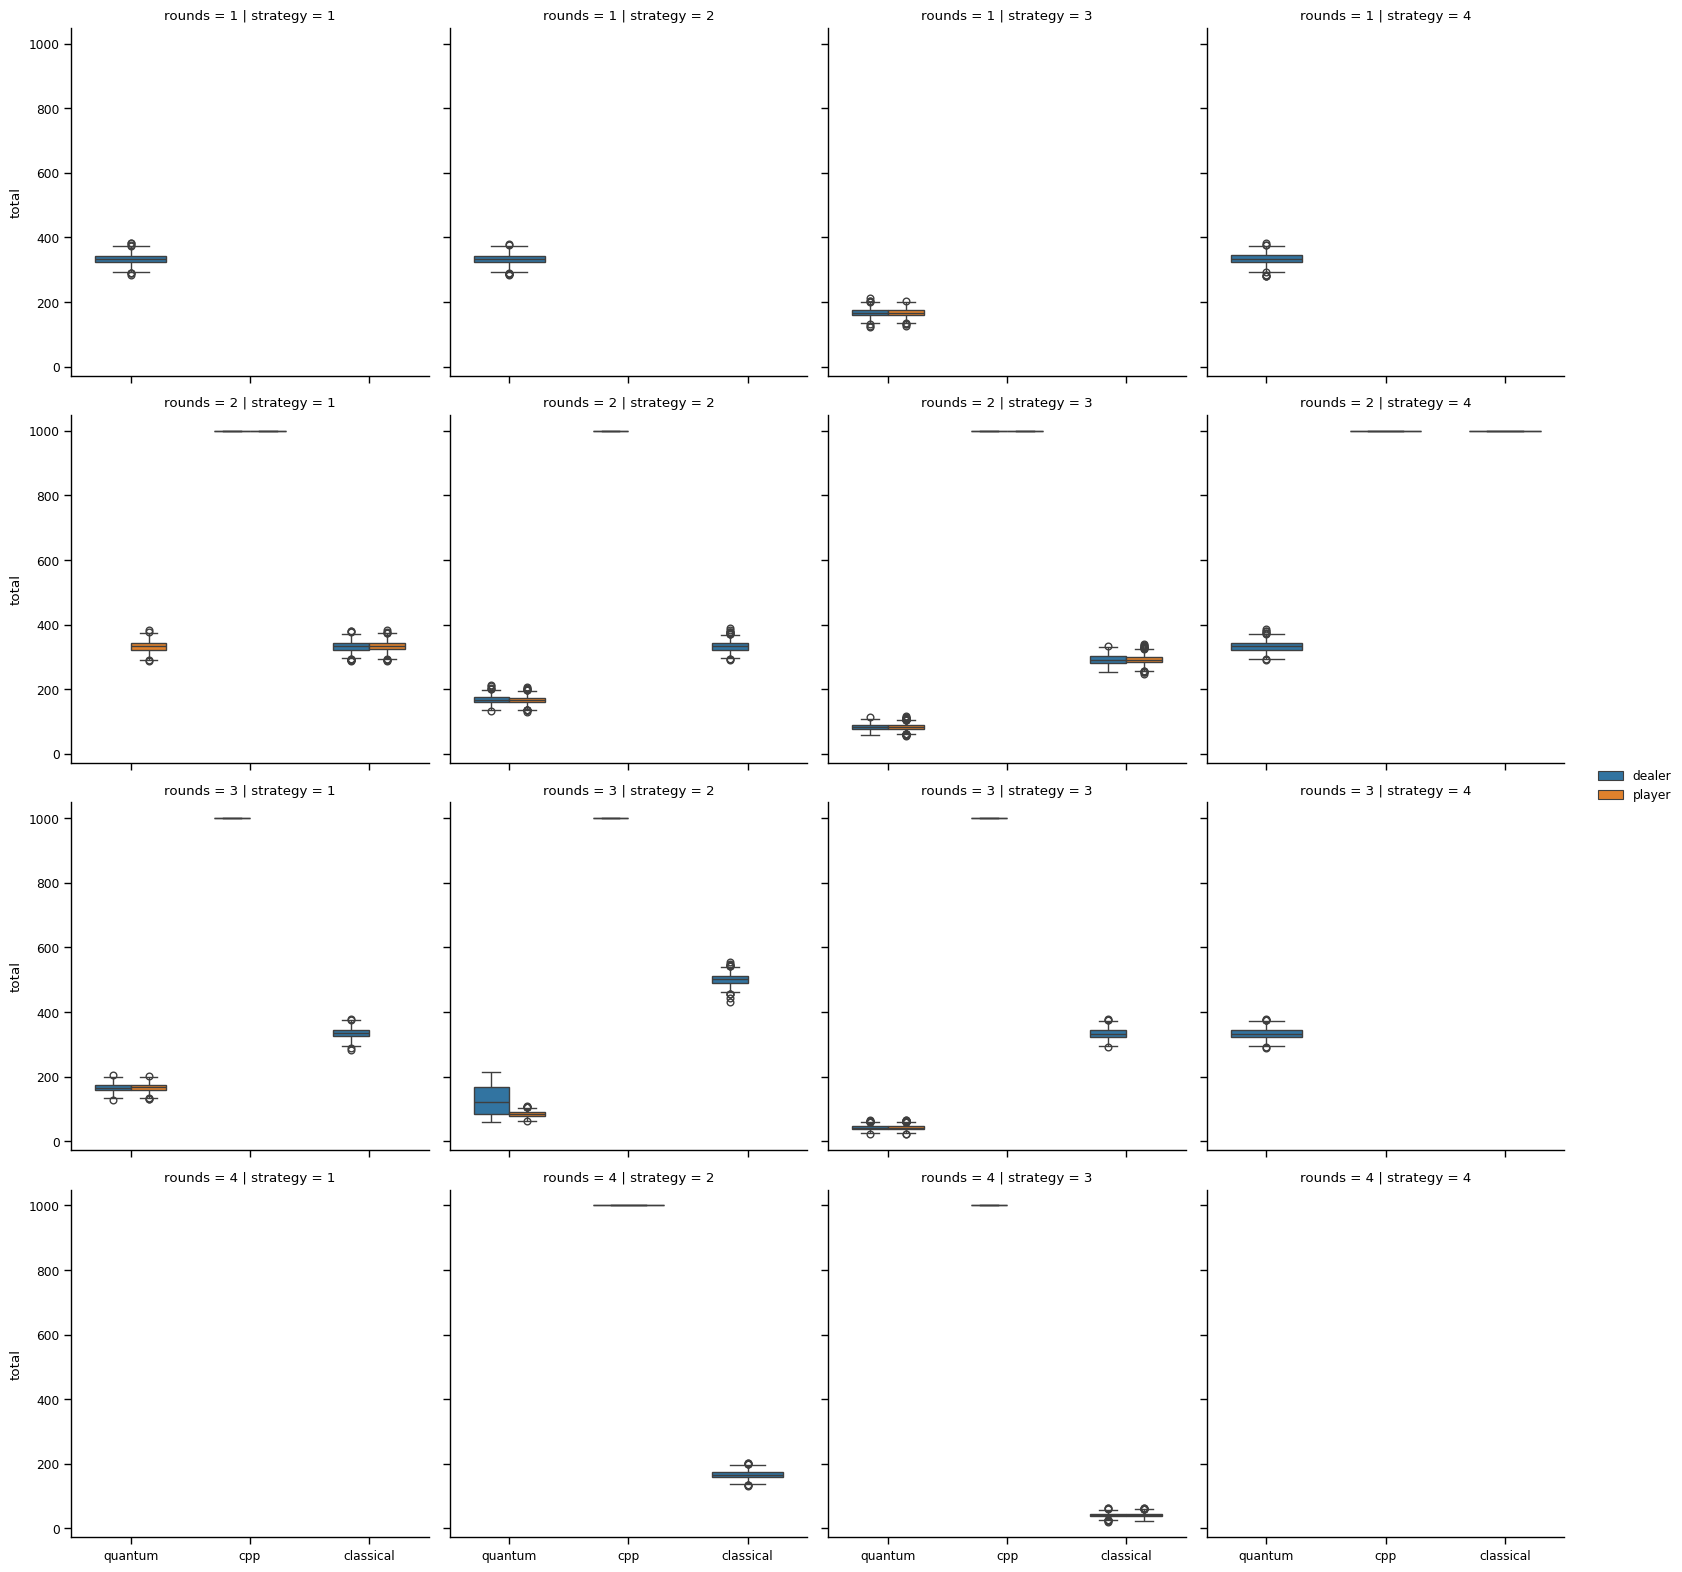

In [35]:
sns.set_context("paper")
g = sns.FacetGrid(data, row="rounds", col="strategy", height=4, aspect=1)
g.map_dataframe(sns.boxplot, y="total", hue="winner", x="label", width=0.6, dodge=True, palette="tab10")
g.add_legend()
g.tight_layout()
g.set_xlabels("")
g.savefig("comparing-results.png")
plt.show()

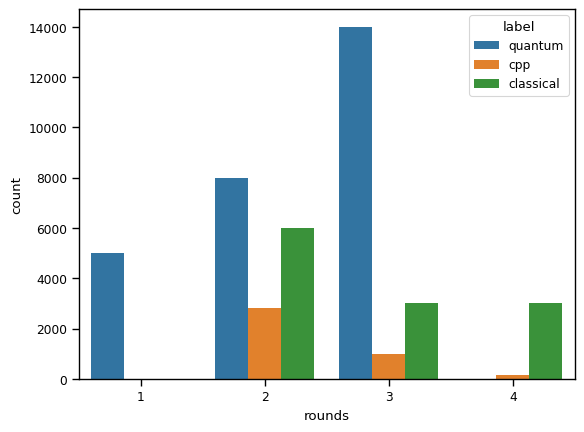

In [36]:
sns.countplot(data=data, x="rounds", hue="label", palette="tab10")
plt.savefig("total_rounds.png", bbox_inches="tight")
plt.show()


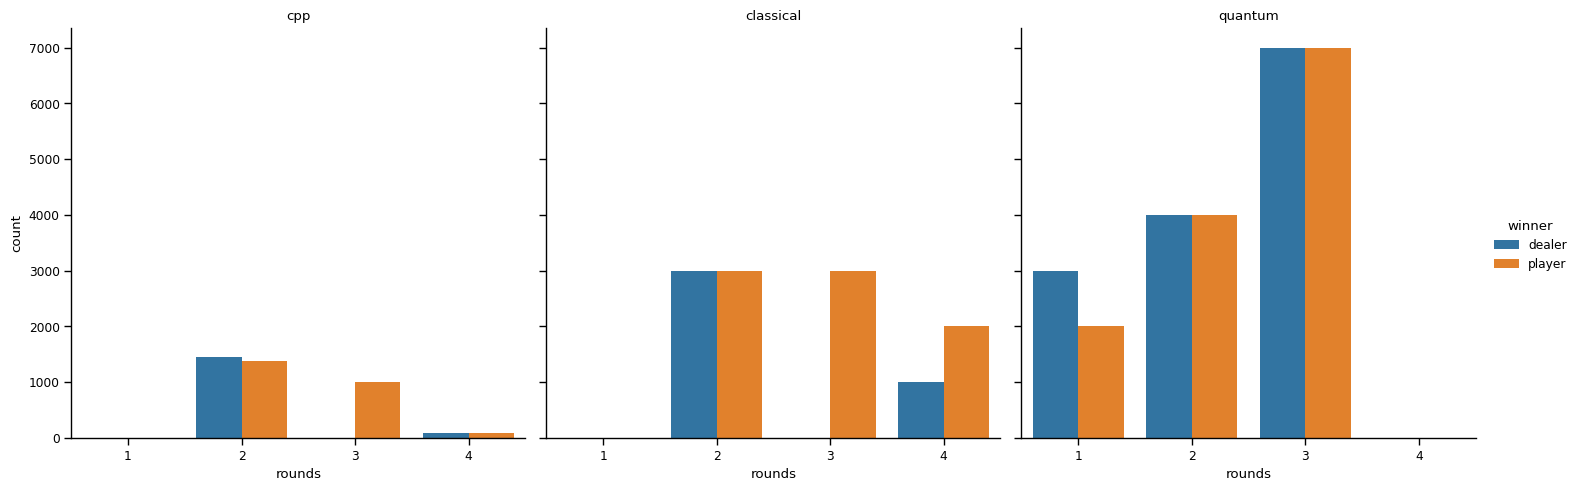

In [47]:
g = sns.catplot(data=data, x="rounds", hue="winner", palette="tab10", col="label", kind="count")
g.set_titles(col_template="{col_name}")
plt.savefig("total_rounds_per_version.png", bbox_inches="tight")
plt.show()
